# Predicting whether a movie is made by Marvel or DC based on its Description

This report takes in a dataset from Kaggle, with the link: https://www.kaggle.com/datasets/hetulmehta/marvel-vs-dc-imdb-dataset. This dataset contains movies and TV shows from the Marvel and DC franchise. The dataset contains the columns 'Movie', 'Year', 'Genre', 'RunTime', 'Rating', 'Director', 'Actor', 'Description', 'IMDB_Score', 'Metascore', 'Votes', 'USA_Gross', 'Category'. Each of the columns have their own importance, but I am only planning to use the Category and Description columns. My plan for this project is to use a vectorizer, either CountVectorizer or a TFIDFVectorizer to convert the words in each description to a vector. From there I have three main types of models to test this on: KNN, SVM, and Logistic Regression. I am doing this because Marvel and DC have been closely compared to be about the same thing. Although I am a Marvel fan, I wanted to settle the difference between them and show that they are conpletely differnet. Even though they have some similarities, I wnat to show that the franchises are so different that a model can differentiate between them based on just their descriptions.

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  Ridge, Lasso, LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

Reading in the data

In [24]:
df = pd.read_csv('Marvel_DC_imdb.csv')

I am removing the columns that I don't want. I feel like it would be too easy for the model to predict between the movies if it has more than just the description, and I want to test the limits a model can go to. I will add more columns back later if needed.

In [25]:
df.columns

Index(['Unnamed: 0', 'Movie', 'Year', 'Genre', 'RunTime', 'Rating', 'Director',
       'Actor', 'Description', 'IMDB_Score', 'Metascore', 'Votes', 'USA_Gross',
       'Category'],
      dtype='object')

In [26]:
df.drop(['Unnamed: 0', 'Movie', 'Year', 'Genre', 'RunTime', 'Rating', 'Director',
       'Actor', 'IMDB_Score', 'Metascore', 'Votes', 'USA_Gross'], axis=1, inplace=True)

Right below, I created a quick function to reload hte dataset and drop the columns I am not using. I did this for convenience, and to shorten my code.

In [27]:
def load_data():
    data = pd.read_csv('Marvel_DC_imdb.csv')
    data.drop(['Unnamed: 0', 'Movie', 'Year', 'Genre', 'RunTime', 'Rating', 'Director',
       'Actor', 'IMDB_Score', 'Metascore', 'Votes', 'USA_Gross'], axis=1, inplace=True)
    return data

Here is a quick analysis of the data. It can be seen that 77% of the data comes from DC shows and movies and the character counts are also 81% DC. This shows me that I should probably be balancing the data set, but I am going to try creating a model on the whole data first.

In [28]:
print('Marvel Data Counts:', len(df[df['Category'] == 'Marvel']))
print('DC Data Counts:', len(df[df['Category'] == 'DC']))
print('Percent of Data that is DC:', len(df[df['Category'] == 'DC'])/(len(df[df['Category'] == 'DC'])+len(df[df['Category'] == 'Marvel'])))

Marvel Data Counts: 389
DC Data Counts: 1301
Percent of Data that is DC: 0.7698224852071006


In [29]:
vals2 = df[df['Category'] == 'Marvel']['Description'].apply(lambda x: len(x.split()))
vals = df[df['Category'] == 'DC']['Description'].apply(lambda x: len(x.split()))

print('Marvel Character Counts:', vals2.sum())
print('DC Character Counts:', vals.sum())
print('Percent of Characters that come from DC:', vals.sum()/(vals.sum()+vals2.sum()))

Marvel Character Counts: 7476
DC Character Counts: 32144
Percent of Characters that come from DC: 0.8113074204946996


I am now going to make a train-test-split. The plan is to run a Countvectorizer and TFIDF on the data. Whichever one works better, which I expect to be TFIDF, is the one I will use.

In [30]:
data = load_data()

X = data['Description']
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

model = SVC(kernel='linear', C=1.0)
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with TFIDF: {accuracy:.4f}")

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

model = SVC(kernel='linear', C=1.0)
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Count Vectorizer: {accuracy:.4f}")

Accuracy with TFIDF: 0.8955
Accuracy with Count Vectorizer: 0.8836


Since TFIDF has a better accuracy, I will be using it. Something I noticed when looking at the dataset is that there are a few words that are in both Marvel and DC descriptions. I was thinking, if I remove those words from the TFIDF Vectorizer, would that result in a better and potentially more accurate model?

In [31]:
data = load_data()

X = data[data['Category'] == 'Marvel']['Description']
y = data[data['Category'] == 'Marvel']['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

features = vectorizer.get_feature_names_out()
term_sums = np.asarray(X_train_counts.sum(axis=0)).flatten()

term_frequencies = list(zip(features, term_sums))

sorted_terms_marvel = sorted(term_frequencies, key=lambda x: x[1], reverse=True)

print("Top 10 highest weighted occurring words in Marvel movies using TFIDF Vectorizer:")
for term, count in sorted_terms_marvel[:10]:
    print(f"{term}: {count}")

Top 10 highest weighted occurring words in Marvel movies using TFIDF Vectorizer:
plot: 60.21528526276032
team: 10.328645818574023
mutant: 6.4426327977305755
new: 5.5415255166578286
coulson: 5.32760013076087
marvel: 4.437636817025147
daisy: 3.8297508445345403
world: 3.754716701685193
time: 3.7482355757814405
save: 3.4017635461146445


In [32]:
data = load_data()

X = data[data['Category'] == 'DC']['Description']
y = data[data['Category'] == 'DC']['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

features = vectorizer.get_feature_names_out()
term_sums = np.asarray(X_train_counts.sum(axis=0)).flatten()

term_frequencies = list(zip(features, term_sums))

sorted_terms_dc = sorted(term_frequencies, key=lambda x: x[1], reverse=True)

print("Top 10 highest weighted occurring words in DC movies using TFIDF Vectorizer:")
for term, count in sorted_terms_dc[:10]:
    print(f"{term}: {count}")

Top 10 highest weighted occurring words in DC movies using TFIDF Vectorizer:
plot: 33.1562751387376
batman: 31.789374583159198
summary: 23.555720772257363
clark: 19.206007345789835
city: 16.913417144045667
gotham: 16.775422947953647
new: 16.359751582449096
team: 15.925583747848592
help: 15.18507729240105
gordon: 13.550816375328768


Right above I did a quick check on the top 10 words and how many times they appear for both Marvel and DC Movies separately. Since I am using a TfIdfVectorizer, the weights caused there to be decimals in the counts. I intially used a CountVectorizer for this, but since there are 1300 DC movies compared to 400 Marvel movies, I thought it would look better to consider weights compared to counts, since DC would always be higher than Marvel. Here is the data for the CountVectorizer if you wanted to look at it:

Top 10 most frequently occurring terms in Marvel movies:  
plot: 66  
team: 66  
mutant: 32  
new: 27  
coulson: 25  
marvel: 19  
world: 18  
daisy: 16  
life: 14   
save: 14


Top 10 most frequently occurring terms in DC movies:  
summary: 154  
batman: 148  
clark: 106  
city: 80  
gotham: 80  
new: 78  
team: 72  
help: 71  
gordon: 69  
lex: 57  

We can see that the 8th highest DC movie word actually appears more than the most occuring Marvel words. Using a TFIDF Vectorizer balances this out more, so I decided to use it. Now I am going to get the words that show up in both lists of 10 words, and put them in the 'stop-words' for the Vectorizer, meaning it skips over them

In [33]:
popular_words = []
words_marvel = sorted_terms_marvel[:10]
words_dc = sorted_terms_dc[:10]

for word in words_marvel:
    for word2 in words_dc:
        if word[0] == word2[0]:
            popular_words.append(word[0])

popular_words

['plot', 'team', 'new']

In [34]:
data = load_data()

X = data['Description']
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words=popular_words)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

model = SVC(kernel='linear', C=1.0)
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with TFIDF: {accuracy:.4f}")

Accuracy with TFIDF: 0.8777


Accuracy: 0.8777120315581854
Accuracy wih Matthews Correlation Test (MCC): 0.6175678288625506


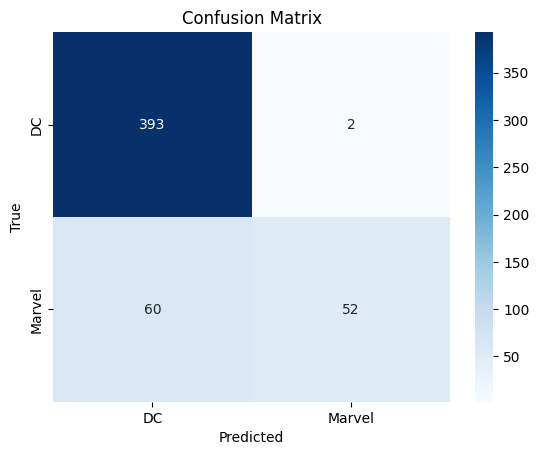

In [35]:
data = load_data()

X = data['Description']
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words=popular_words)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

model = SVC(kernel='linear', C=1.0)
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)
classes = ['DC', 'Marvel']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.plot()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Accuracy wih Matthews Correlation Test (MCC):", matthews_corrcoef(y_test, y_pred))

I found that it acctually makes it worse, and I'm not very sure why. My idea is that the Marvel dataset relied a lot on the words I took out, and by removing them, there were less words that made a differnece and were overpowered by the DC dataset. My next idea is to make the two categories the same size by taking a random 389 values from the DC. Something interesting I noticed in the Confusion matrix is that almost all of the wrong values were on one side, where a Marvel movie was predicted to be a DC movie. This supports what I thought, and I think that continuing on this route might have some potential, but I want to try my other idea first. By sampling 389 words from the DC section of the dataset, it would be balanced. I also want to try to balance the dataset and then compare it to the original one, maybe that would increase the accuracy?

Accuracy: 0.8504
Accuracy wih Matthews Correlation Test (MCC): 0.699651673826566


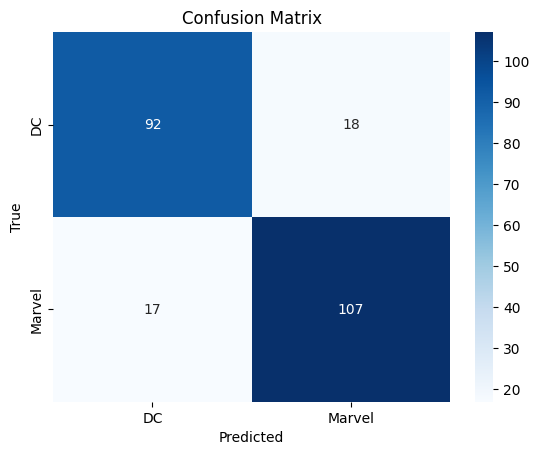

In [36]:
## To do: fix this code by usig the tfidf first then splitting and testing, and testing again on the entire dataset
data = load_data()

data = pd.concat([data[data['Category'] == 'Marvel'], data[data['Category'] == 'DC'].sample(n=len(data[data['Category'] == 'Marvel']), random_state=42)])
X = data['Description']
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words=popular_words)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

model = SVC(kernel='linear', C=1.0)
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

classes = ['DC', 'Marvel']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.plot()

print("Accuracy wih Matthews Correlation Test (MCC):", matthews_corrcoef(y_test, y_pred))

Somehow, the accuracy decreased yet again. I am not sure why, because it was the all the DC ones that were marked incorrectly. My assumption is that there was not enough data for hte model to differentiate between the two. I wnat to now try a method to fix the wrong DC tests. I changed the clas weights in my SVC to balanced, as anoter to way balance the data

In [37]:
data = load_data()

X = data['Description']
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

model = SVC(kernel='linear', C=1.0, class_weight='balanced')
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with TFIDF: {accuracy:.4f}")
print("Accuracy wih Matthews Correlation Test (MCC):", matthews_corrcoef(y_test, y_pred))

Accuracy with TFIDF: 0.8698
Accuracy wih Matthews Correlation Test (MCC): 0.6512071764350531


This test also did not work. I am not sure why yet agian, but my next idea is to try using KNN instead of SVM's. I will also use a list to find the best K-value that works, and create a confusion matrix for that

Accuracy with KNN: 0.8540
Accuracy wih Matthews Correlation Test (MCC): 0.5408337262938472


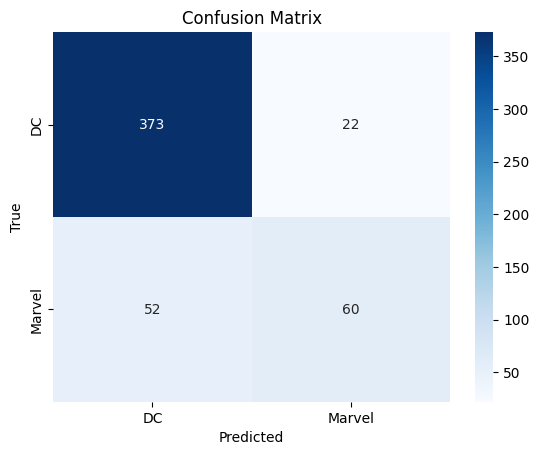

In [38]:
data = load_data()

X = data['Description']
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

model = KNeighborsClassifier()
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with KNN: {accuracy:.4f}")

classes = ['DC', 'Marvel']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.plot()
print("Accuracy wih Matthews Correlation Test (MCC):", matthews_corrcoef(y_test, y_pred))

Best k value: 11 with accuracy: 0.873767258382643


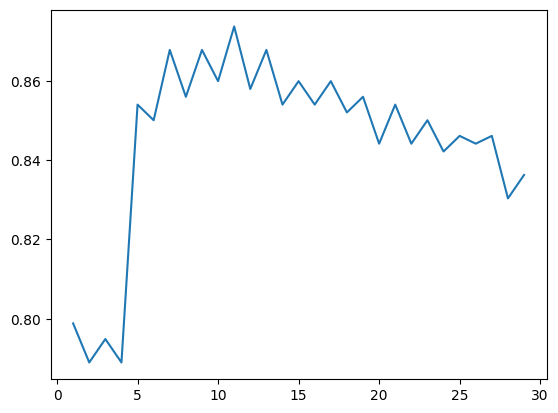

In [39]:
accuracies = []
k_vals = [i for i in range(1, 30)]

for k in k_vals:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_counts, y_train)
    y_pred = model.predict(X_test_counts)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.plot(k_vals, accuracies)
print("Best k value:", k_vals[np.argmax(accuracies)], "with accuracy:", max(accuracies))

Accuracy with KNN: 0.8679
Accuracy wih Matthews Correlation Test (MCC): 0.5916142601264548


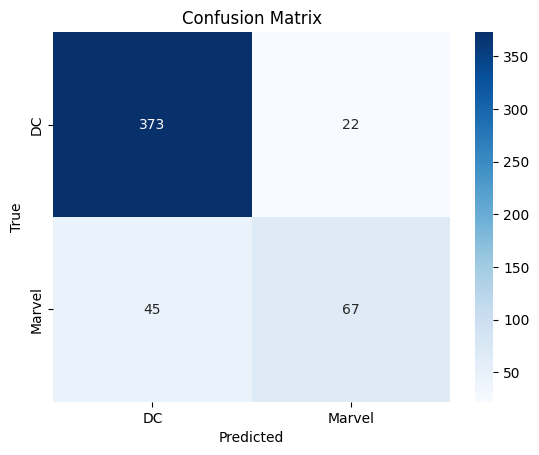

In [40]:
data = load_data()

X = data['Description']
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with KNN: {accuracy:.4f}")

classes = ['DC', 'Marvel']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.plot()
print("Accuracy wih Matthews Correlation Test (MCC):", matthews_corrcoef(y_test, y_pred))

Changing the model I used to a KNN did not help either, the accuracy is lower, but it is really close, as 89.35 is only .2% away from 89.55%. An SVM is probably just a better version of a KNN in this dataset. Since classificatoin models based on proximity like SVM and KNN have a theoretical max accuracy of 89.55%, I want to try using a Logisitc Regression with the tfidf vectorizer to see if it results in a better model.

Accuracy with Logisitc Regression: 0.8560
Accuracy wih Matthews Correlation Test (MCC): 0.5430004518261654


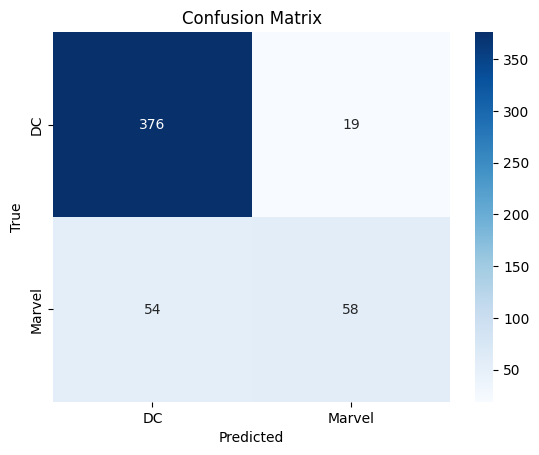

In [41]:
data = load_data()

X = data['Description']
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

model = LogisticRegression()
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Logisitc Regression: {accuracy:.4f}")

classes = ['DC', 'Marvel']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.plot()
print("Accuracy wih Matthews Correlation Test (MCC):", matthews_corrcoef(y_test, y_pred))

This is a quick piece of code to remove warnings

In [42]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

I just tried to use Logisitic Regression to see if it could be a higher accuracy. I intiallly put no parameters into the model, and got an acccuracy and confusion matrix similar to the one where I took out the most popular words and KNN. I want to try using GridSearchCV to ifnd the best parameters for the model, and hopefullt it will be better than an SVM. I am going to change the penalty, C, solver, max_iter, class_weight, and l1_ratio parameters

In [43]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    { 
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],  
        'max_iter': [100, 500, 1000],
        'class_weight': [None, 'balanced']
    },
    {  
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.1, 0.5, 0.9],     
        'solver': ['saga'],             
        'max_iter': [100, 500, 1000],
        'class_weight': [None, 'balanced']
    },
    {  
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga', 'newton-cg'],  
        'max_iter': [100, 500, 1000],
        'class_weight': [None, 'balanced']
    }
]

data = load_data()

X = data['Description']
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring = 'accuracy')
grid_search.fit(X_train_counts, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

print("Test Set Accuracy:", grid_search.score(X_test_counts, y_test))

Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validation Score: 0.90955803475649
Test Set Accuracy: 0.8954635108481263


I got Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'} with accuracy of 89.55%, the same as an SVM. I'm not sure if I can increase the accuracy of the SVM much, but using a parameter grid gave me the idea to run one on the SVM, so I am going to try that. I will change the C, kernel, gamma, class_weight, and shrinking parameters.

In [44]:
param_grid = {
    'C': [0.1, 1, 10, 100],                
    'kernel': ['linear', 'rbf'],           
    'gamma': ['scale', 'auto', 0.1, 1],    
    'class_weight': [None, 'balanced'],    
    'shrinking': [True, False]         
}

data = load_data()

X = data['Description']
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring = 'accuracy')
grid_search.fit(X_train_counts, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

print("Test Set Accuracy:", grid_search.score(X_test_counts, y_test))

Best Parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': True}
Best Cross-Validation Score: 0.9044947436172496
Test Set Accuracy: 0.8856015779092702


Somehow the accuracy went down, I think theres some more parameters that make it better that will require more time for this to run, but I think I'll leave it there. I have completely run out of ideas to improve my model, so here is the final version.

Accuracy with TFIDF: 0.8955
Accuracy wih Matthews Correlation Test (MCC): 0.6916617586852754


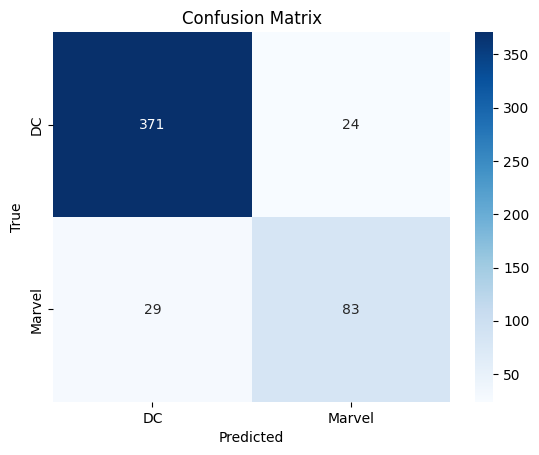

In [45]:
data = load_data()

X = data['Description']
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

model = SVC(kernel='linear', C=1.0)
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with TFIDF: {accuracy:.4f}")

classes = ['DC', 'Marvel']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.plot()
print("Accuracy wih Matthews Correlation Test (MCC):", matthews_corrcoef(y_test, y_pred))

In [46]:
import random
from sklearn.model_selection import cross_val_score

random_states = [random.randint(0, pow(2,32)-1) for i in range(1000)]
# print(random_states)
accuracies = []

for val in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=val)

    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X_train_counts = vectorizer.fit_transform(X_train)
    X_test_counts = vectorizer.transform(X_test)

    model = SVC(kernel='linear', C=1.0)
    model.fit(X_train_counts, y_train)
    y_pred = model.predict(X_test_counts)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")
print("Accuracy wih Matthews Correlation Test (MCC):", matthews_corrcoef(y_test, y_pred))

Mean Accuracy: 0.8990
Standard Deviation: 0.0117
Accuracy wih Matthews Correlation Test (MCC): 0.74382180503121


My code is taking the descriptions of Marvel and DC movies, and returning what it predicts the brand to be. I am using a Support Vector Machine to do this, and my confusion matrix is very balanced. There is about an equal amount of wrong predictions for both Marvel and DC. Although the dataset is slightly imbalanced, at a ratio of approxiamtely 3:1, I am content with the results. In the cell above I took 1000 random states and calculated the average accuracy to get a true estimate for the average accuracy of the model. I got a final average accuracy of 89.9 with a standard deviation of 0.0117.